In [1]:
## Load Data -> Data downloaded from https://data.world/fivethirtyeight/russian-troll-tweets

# TODO Remove unused columns
# Average number of followers for bot account -> avg for leftTroll, avg for rightTroll

In [2]:
import pandas as pd
import numpy as np
import io
import datetime
import matplotlib
import requests
import re

In [3]:
df = pd.read_csv('data.csv')
print(df)

       Unnamed: 0  external_author_id           author  \
0          131642        1.512372e+09  CATELINEWATKINS   
1          272846        2.611151e+09     SEATTLE_POST   
2          277728        2.620614e+09   PHILADELPHIAON   
3          163829        8.980000e+17      CHARMEESTRS   
4          243436        3.272641e+09          EXQUOTE   
5          281917        2.611151e+09     SEATTLE_POST   
6           61300        1.914761e+09    RAVENICHOLSON   
7          207341        4.440342e+09  ARGENTINACATLE1   
8          202716        2.570017e+09    ONLINEMEMPHIS   
9           13368        2.329890e+09        POLITKACH   
10         387417        1.661246e+09    KATERITTERRRR   
11         215343        2.943515e+09    SCREAMYMONKEY   
12          78942        2.591848e+09    TODAYBOSTONMA   
13         200944        2.547142e+09  CHICAGODAILYNEW   
14         108447        3.899482e+09     TODAYINSYRIA   
15          35399        1.868496e+09    BRIANAREGLAND   
16         203

In [4]:
# Delete unused columns
df = df.drop(['external_author_id', 'harvested_date', 'following', 'updates', 'post_type', 'new_june_2018', 'retweet'], axis=1)
df

,Unnamed: 0,author,content,region,language,publish_date,followers,account_type,account_category
0,131642,CATELINEWATKINS,#ThingsYouCantIgnore Morning breath,United States,English,12/19/2016 15:56,2589,Hashtager,HashtagGamer
1,272846,SEATTLE_POST,Quarterback Everett Golson to transfer from No...,United States,English,5/7/2015 19:08,11483,local,NewsFeed
2,277728,PHILADELPHIAON,PA House Approves Bill Cracking Down On ‘Stop-...,United States,English,6/27/2017 21:29,16786,local,NewsFeed
3,163829,CHARMEESTRS,‘Tyranny of Political Correctness’ Forced Boy ...,Unknown,English,10/12/2017 12:22,1996,Right,RightTroll
4,243436,EXQUOTE,http://t.co/yeGVLw5A9C About to Eat then Go Wo...,United States,English,7/16/2015 9:40,291,Commercial,Commercial
5,281917,SEATTLE_POST,Spanaway bank closed after employees say subst...,United States,English,9/19/2015 2:43,12867,local,NewsFeed
6,61300,RAVENICHOLSON,Looking forward to reading this. https://t.co/...,United States,English,11/30/2016 1:30,800,left,LeftTroll
7,207341,ARGENTINACATLE1,"HOT MORNING GOSSIP - @MileyCyrus, Wild Child, ...",United States,English,5/25/2016 13:06,20,left,LeftTroll
8,202716,ONLINEMEMPHIS,Robert Arnold's cousin fired from Rutherford s...,United States,English,1/7/2017 4:04,18612,local,NewsFeed
9,13368,POLITKACH,Информатор WikiLeaks Челси Мэннинг попыталась ...,United Arab Emirates,Uzbek,7/7/2016 10:45,8977,Russian,NonEnglish


In [5]:
# Use regex to figure out if the tweet mentions a few relevant political figures 

trump_regex = re.compile(r'(Donald|Trump)')
hill_regex = re.compile(r'(Hillary|Clinton)')
bernie_regex = re.compile(r'(Bernie)')
obama_regex = re.compile(r'(Obama)')
cruz_regex = re.compile(r'(Ted Cruz|Cruz)')
beto_regex = re.compile(r'(Beto|O\'Rourke)')

for i, row in df.iterrows():
    df.at[i, 'mention'] = ''
    search_string = str(row['content'])
    if re.search(trump_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Trump '
    if re.search(hill_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Hillary '
    if re.search(bernie_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Bernie '
    if re.search(obama_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Obama '
    if re.search(cruz_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Cruz '
    if re.search(beto_regex, search_string):
        df.at[i, 'mention'] = df.at[i, 'mention'] + 'Beto '

for i, row in df.iterrows():
    if df.at[i,'mention'] is '':
        df.at[i,'mention'] = np.nan
df = df.dropna()
df = df.reset_index()
df = df.drop(labels='index', axis=1)


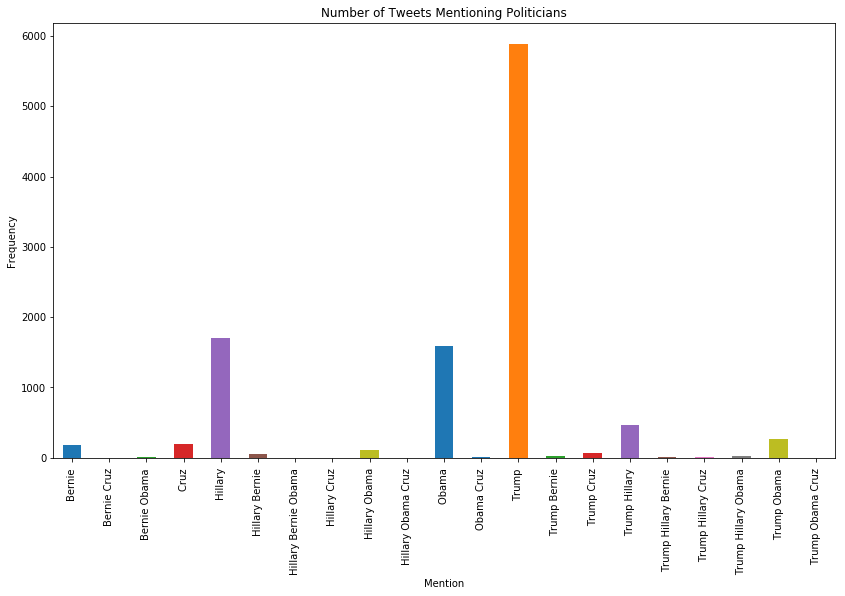

In [6]:
%matplotlib inline
ax = df.groupby(by='mention')['mention'].count().plot.bar(title="Number of Tweets Mentioning Politicians", figsize=(14,8))
_ = ax.set_xlabel('Mention')
_ = ax.set_ylabel('Frequency')




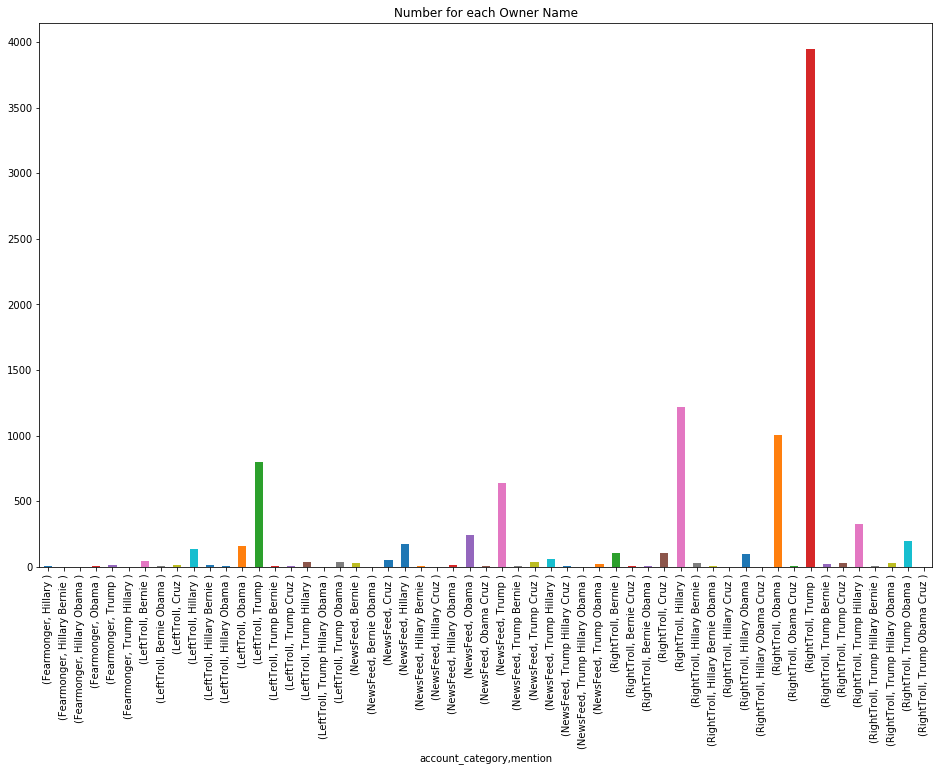

In [7]:
df = df[df.account_category != 'HashtagGamer']
df = df[df.account_category != 'Commercial']
df = df[df.account_category != 'Unknown']
df = df[df.account_category != 'NonEnglish']
ax = df.groupby(['account_category', 'mention'])['mention'].count().plot.bar(title="Number for each Owner Name", figsize=(16,10))


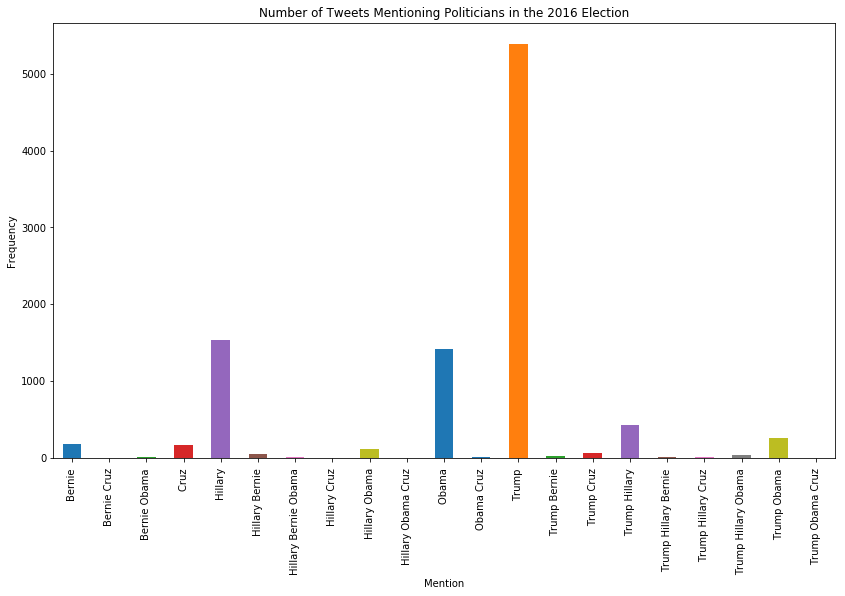

In [8]:
election_df = df[df['mention'].str.contains("Trump|Hillary|Bernie")==True]

%matplotlib inline
ax = df.groupby(by='mention')['mention'].count().plot.bar(title="Number of Tweets Mentioning Politicians in the 2016 Election", figsize=(14,8))
_ = ax.set_xlabel('Mention')
_ = ax.set_ylabel('Frequency')

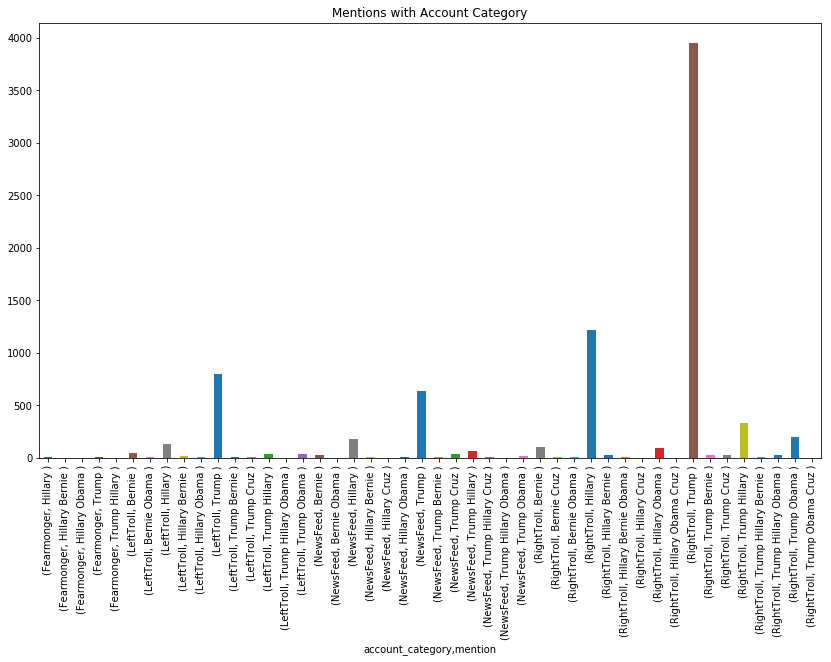

In [9]:
ax = election_df.groupby(['account_category', 'mention'])['mention'].count().plot.bar(title="Mentions with Account Category", figsize=(14,8))

In [10]:
right_re = re.compile(r'(Cruz|Trump)')
left_re = re.compile(r'(Beto|Hillary|Obama|Bernie)')
for i, row in df.iterrows():
    mention = str(row.mention)
    if re.search(right_re, mention) and re.search(left_re, mention):
        df.at[i, 'score'] = 0
    elif re.search(right_re, mention) and row.account_category == 'RightTroll':
        df.at[i, 'score'] = 1
    elif re.search(left_re, mention) and row.account_category == 'LeftTroll': 
        df.at[i, 'score'] = 1
    else:
        df.at[i, 'score'] = -1
df.head()

,Unnamed: 0,author,content,region,language,publish_date,followers,account_type,account_category,mention,score
0,35399,BRIANAREGLAND,We will spend more time discussing Trump's pus...,United States,English,10/8/2016 2:32,761,left,LeftTroll,Trump,-1.0
1,361319,STANLEYPARRIS,"While visiting Trump's White House, this NFL p...",United States,English,4/24/2017 10:45,814,left,LeftTroll,Trump Obama,0.0
2,162971,MARISSAIMSTRONG,"Friday, FBI trying to keep track of 48 known I...",United States,English,11/28/2015 13:34,409,Right,RightTroll,Obama,-1.0
3,43055,TEN_GOP,Watch anti-Trump protester screams in the face...,United States,English,10/26/2016 21:54,46949,Right,RightTroll,Trump Hillary,0.0
4,31281,PRETTYLARAPLACE,As #Trump surges in the polls #Democrats are s...,United States,English,9/16/2016 18:13,1798,Right,RightTroll,Trump,1.0


For our Null-Hypothesis, we hypothesize that the tweets that mention Democratic candidates come from LeftTroll Accounts while tweets that mention Republican candidates come from RightTroll accounts.  In order to score this, we gave each row a value of 1, 0, or -1.  1 For a correct matching, 0 for both candidates being mentioned, and -1 for different sides.  To see what has the majority, we will simply sum the column.

In [11]:
df['score'].sum(axis=0)

-52.0

This sum indicates that most russian bot tweets mention canidates in opposing political parties than the narrative the accounts are trying to push.  Based on this, we can come to the conclusion that most bot tweets are trying to paint specific canidates in negative light instead of trying to promote the politicians that they align with.  

In [12]:
# do another hypothesis test with the goal of showing that the majority of bot tweets are promoting a conservative view point
# right troll vs left troll

# drop all not mentioning clinton and trump
# count number of tweets after election still including clinton

# get count of number of negative con tweets (right troll and clinton)
# get count of number of pos con tweets (right troll and trump)
# get count of number of neg dem tweets (left and trump)
# get count of number of pos dem tweets (left and clinton)



In [13]:
clinton_re = re.compile(r'(Hillary)')

count = 0
for i, row in df.iterrows():
    if re.search(clinton_re, row['mention']) and row['account_category'] == 'RightTroll':
        count += 1
count

1712

In [14]:
trump_re = re.compile(r'(Trump)')

count = 0
for i, row in df.iterrows():
    if re.search(trump_re, row['mention']) and row['account_category'] == 'RightTroll':
        count += 1
count

4558

In [15]:
count = 0
for i, row in df.iterrows():
    if re.search(clinton_re, row['mention']) and row['account_category'] == 'LeftTroll':
        count += 1
count

184

In [16]:
count = 0
for i, row in df.iterrows():
    if re.search(trump_re, row['mention']) and row['account_category'] == 'LeftTroll':
        count += 1
count

871

In [17]:
df['publish_date'] = pd.to_datetime(df['publish_date'])
election_date = pd.to_datetime('November 8, 2016')

pre_df = df[df['publish_date'] <= election_date]

count = 0
for i, row in pre_df.iterrows():
    if re.search(clinton_re, row['mention']):
        count += 1
count

1363

In [18]:
#Tweets mentioning Trump Clinton before and after election



post_df = df[df['publish_date'] > election_date]

count = 0
for i, row in post_df.iterrows():
    if re.search(clinton_re, row['mention']):
        count += 1
count

800

In [19]:
pre_df = df[df['publish_date'] <= election_date]

count = 0
for i, row in pre_df.iterrows():
    if re.search(trump_re, row['mention']):
        count += 1
count

1699

In [20]:
post_df = df[df['publish_date'] > election_date]

count = 0
for i, row in post_df.iterrows():
    if re.search(trump_re, row['mention']):
        count += 1
count

4504

In [21]:
count = 0
for i, row in post_df.iterrows():
    if re.search(trump_re, row['mention']) and row['account_category'] == 'RightTroll':
        count += 1
count

3599

In [23]:
# Summary of followers for different account categories
df.groupby('account_category')['followers'].agg([pd.np.min, pd.np.max, pd.np.mean])

,amin,amax,mean
account_category,,,
Fearmonger,0,94,57.040000
LeftTroll,3,54714,2534.774818
NewsFeed,1,61952,15689.747467
RightTroll,0,144680,4718.766143
